## **RQ2**

### **Can predictive models identify and explain differences in volatility, cumulative returns, and average daily returns between core entertainment/media companies and extra (diversified) companies in Canada?**

###  Hypotheses: 

##### H0: Predictive models do not identify any statistically significant differences in volatility, cumulative returns, or average daily returns between core and extra companies. 

##### H1: Predictive models identify statistically significant differences in volatility, cumulative returns, or average daily returns between core and extra companies. 

For RQ2, the things we want to compare are:
* Volatility
* Cumulative return
* Average daily return

Category (Core vs Extra) — the main explanatory variable that directly answers the hypothesis.
Optionally, control variables like Ticker (company dummies), Volume, or Date (time trends) can be included, but Category is the key.

Target (Y):
* Volatility (numeric)
* or Cumulative return (numeric)
* or Average daily return (numeric)


Features (X):
* Category (Core=1, Extra=0)

The prediction task is:

“Given a company’s group (Core vs Extra), can we predict its volatility, cumulative return, or average daily return — and are those predictions significantly different?

In [1]:
#Predict Y for all 8 companies

In [2]:
import pandas as pd
data=pd.read_csv('entertainment_stocks.csv')

In [3]:
data.dtypes

Date             object
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Ticker           object
Company          object
Exchange         object
Category         object
Price           float64
Daily_Return    float64
MA5             float64
MA20            float64
Above_MA20      float64
dtype: object

### **Data Preparation**

In [4]:
#Keep useful columns
data= data[['Date', 'Ticker', 'Company', 'Category', 'Daily_Return']]

#Convert Date
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(['Ticker', 'Date'])

/var/folders/br/ng89_vjs55b9fqgsky6n1_9m0000gn/T/ipykernel_10118/1858900951.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


In [5]:
#Create Volatility
#Use a rolling 20-day window for each company (grouped by Ticker)
data['Volatility_20'] = data.groupby('Ticker')['Daily_Return'].rolling(window=20).std().reset_index(0, drop=True)

In [6]:
#Create Cumulative Return
#Within each company, take cumulative product of (1 + Daily_Return) minus 1
data = data.sort_values(['Ticker', 'Date'])
# cumulative return per ticker
data['Cumulative_Return'] = (1.0 + data['Daily_Return']).groupby(data['Ticker']).cumprod() - 1.0

In [7]:
#Create Average Daily Return
data['Avg_Daily_Return'] = data.groupby('Ticker')['Daily_Return'].transform('mean')

In [8]:
data.head()

,Date,Ticker,Company,Category,Daily_Return,Volatility_20,Cumulative_Return,Avg_Daily_Return
0,2020-08-13 00:00:00-04:00,CCA.TO,Cogeco Communications,Extra,-0.014993,NaN,-0.014993,-0.000121
1,2020-08-14 00:00:00-04:00,CCA.TO,Cogeco Communications,Extra,0.000884,NaN,-0.014122,-0.000121
2,2020-08-17 00:00:00-04:00,CCA.TO,Cogeco Communications,Extra,0.017661,NaN,0.003289,-0.000121
3,2020-08-18 00:00:00-04:00,CCA.TO,Cogeco Communications,Extra,-0.005592,NaN,-0.002321,-0.000121
4,2020-08-19 00:00:00-04:00,CCA.TO,Cogeco Communications,Extra,0.010568,NaN,0.008222,-0.000121


In [9]:
data.shape

(10032, 8)

In [10]:
data.isnull().sum()

Date                   0
Ticker                 0
Company                0
Category               0
Daily_Return           0
Volatility_20        152
Cumulative_Return      0
Avg_Daily_Return       0
dtype: int64

Each ticker needs its first 20 days of returns before a 20-day rolling std can be computed.
With 8 companies × ~19 rows each = ~152 missing.

Drop them → safest, because they don’t carry valid information. 

(Losing ~19 days out of thousands per firm won’t bias much.)

In [11]:
print("Before:", data.shape)
data = data.dropna(subset=["Volatility_20"])
print("After:", data.shape)

Before: (10032, 8)
After: (9880, 8)


In [12]:
print(data['Category'].unique())

['Extra' 'Core']


In [13]:
#Core=0 Extra=1
category_map = {'Core': 0, 'Extra': 1}
data['Category_num'] = data['Category'].map(category_map)

# Sanity check
print(data[['Category', 'Category_num']].drop_duplicates())

     Category  Category_num
19      Extra             1
1273     Core             0


### **Exploratory checks**

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

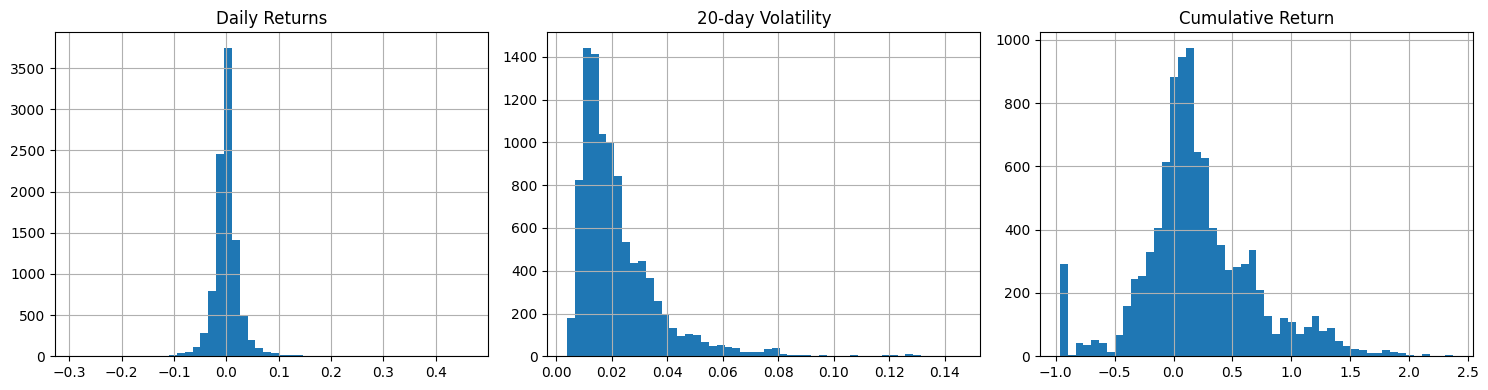

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
data['Daily_Return'].hist(bins=50, ax=axes[0])
axes[0].set_title("Daily Returns")

data['Volatility_20'].hist(bins=50, ax=axes[1])
axes[1].set_title("20-day Volatility")

data['Cumulative_Return'].hist(bins=50, ax=axes[2])
axes[2].set_title("Cumulative Return")

plt.tight_layout()
plt.show()

Daily_Return --> looks symmetric but fat-tailed (not strongly skewed, just heavy tails).
* Sharp peak around 0, with fat tails (classic financial returns shape).
* Core and Extra look similar, both tightly centered with some outliers.
* Not normally distributed

Volatility_20 --> right-skewed (long positive tail).
* Core companies (orange) tend to have higher volatility than Extra (blue).
* Extra distribution is more tightly packed near low volatility values (0.01–0.02).
* Core shows a wider spread with a long right tail → suggests stronger variability.

Cumulative_Return --> right-skewed (many small, some very large positive).
* Very different shapes:
* Extra is tightly clustered around 0–0.5,
* Core is more dispersed, with some negative and many higher positive returns.
* This is the clearest separation between groups so far.

The distributions already hint that Category (Core vs Extra) might explain differences in volatility and cumulative return.
**This supports running regression models with Category as main predictor.**

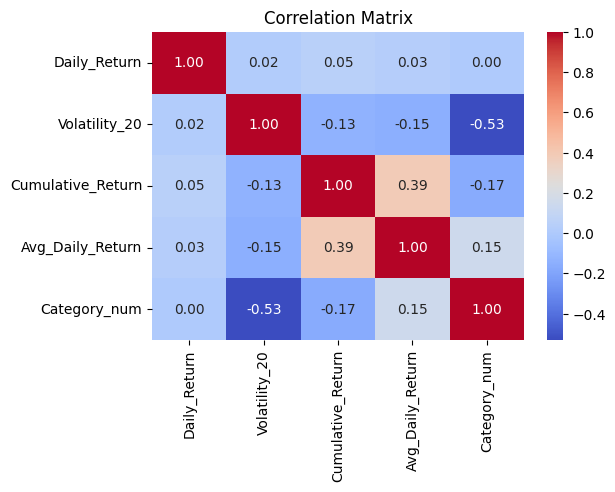

In [16]:
corr = data[['Daily_Return','Volatility_20','Cumulative_Return','Avg_Daily_Return','Category_num']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

* Daily_Return vs Volatility_20 (≈ 0.02) --> No meaningful relationship.
* Daily_Return vs Cumulative_Return (≈ 0.05) --> Very weak positive. Daily short-term returns don’t strongly drive long-term cumulative growth in this dataset.
* Volatility_20 vs Cumulative_Return (≈ –0.13) --> Weak negative correlation. Slight suggestion that higher volatility may hurt long-term returns (fits financial intuition)

The three outcome variables (Daily_Return, Volatility_20, Cumulative_Return) are largely independent.

The three outcome variables are essentially orthogonal:
* Daily_Return → short-term profitability
* Volatility_20 → risk/uncertainty
* Cumulative_Return → long-term growth
This justifies separate models for each outcome in RQ2.

So for RQ2, **it’s justified to model them separately — each is its own predictive task with Category as the main explanatory variable.**

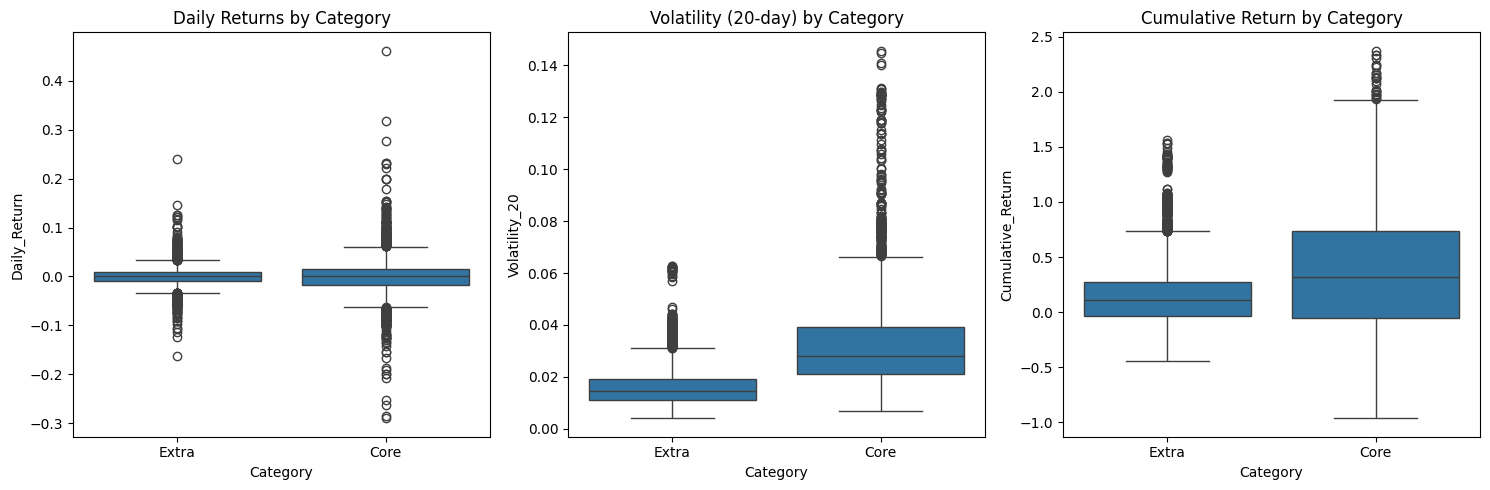

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x="Category", y="Daily_Return", data=data, ax=axes[0])
sns.boxplot(x="Category", y="Volatility_20", data=data, ax=axes[1])
sns.boxplot(x="Category", y="Cumulative_Return", data=data, ax=axes[2])

axes[0].set_title("Daily Returns by Category")
axes[1].set_title("Volatility (20-day) by Category")
axes[2].set_title("Cumulative Return by Category")

plt.tight_layout()
plt.show()

* Daily Returns by Category -->  no mean difference.
* Volatility --> Clear separation
* Core is riskier (more extreme outcomes, positive and negative), while Extra is steadier with modestly higher typical returns.

## **Outliers**

* Daily_Return → symmetric, so no log possible; winsorize outliers only.
* Volatility_20 → strictly positive + right-skewed → log transform.
* Cumulative_Return → positive + right-skewed → log(1 + Cumulative_Return) [It has some negatives]

In [18]:
import numpy as np

In [19]:
data['Log_Volatility_20'] = np.log(data['Volatility_20'] + 1e-6)
data['Log_CumReturn'] = np.log1p(data['Cumulative_Return'])
lower, upper = data['Daily_Return'].quantile([0.01, 0.99])
data['Winsorized_Return'] = data['Daily_Return'].clip(lower, upper)

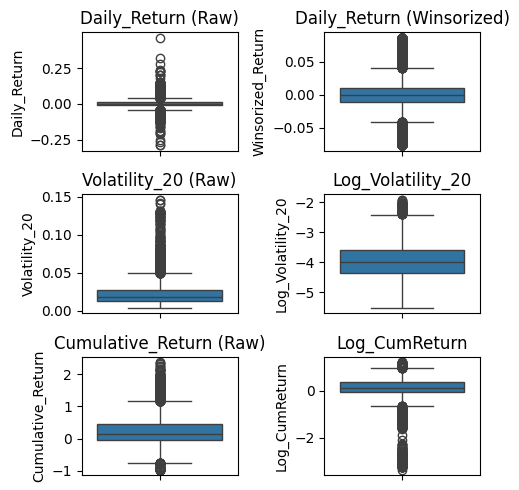

===== IQR Outlier Counts =====
Daily_Return: Before=825, After=825
Volatility_20: Before=551, After=69
Cumulative_Return: Before=877, After=573


In [21]:
def iqr_outlier_count(series):
    """Count outliers using 1.5*IQR rule"""
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()

# --- Daily_Return: winsorize ---
lower, upper = data['Daily_Return'].quantile([0.01, 0.99])
data['Winsorized_Return'] = data['Daily_Return'].clip(lower, upper)

# --- Volatility_20: log transform ---
data['Log_Volatility_20'] = np.log(data['Volatility_20'] + 1e-6)

# --- Cumulative_Return: log1p transform ---
data['Log_CumReturn'] = np.log1p(data['Cumulative_Return'])

# --- Boxplots before vs after ---
fig, axes = plt.subplots(3, 2, figsize=(5, 5)) 

# Daily Return
sns.boxplot(y=data['Daily_Return'], ax=axes[0,0])
axes[0,0].set_title("Daily_Return (Raw)")
sns.boxplot(y=data['Winsorized_Return'], ax=axes[0,1])
axes[0,1].set_title("Daily_Return (Winsorized)")

# Volatility
sns.boxplot(y=data['Volatility_20'], ax=axes[1,0])
axes[1,0].set_title("Volatility_20 (Raw)")
sns.boxplot(y=data['Log_Volatility_20'], ax=axes[1,1])
axes[1,1].set_title("Log_Volatility_20")

# Cumulative Return
sns.boxplot(y=data['Cumulative_Return'], ax=axes[2,0])
axes[2,0].set_title("Cumulative_Return (Raw)")
sns.boxplot(y=data['Log_CumReturn'], ax=axes[2,1])
axes[2,1].set_title("Log_CumReturn")

plt.tight_layout()
plt.show()

# --- IQR outlier counts ---
print("===== IQR Outlier Counts =====")
for col, trans_col in [
    ("Daily_Return", "Winsorized_Return"),
    ("Volatility_20", "Log_Volatility_20"),
    ("Cumulative_Return", "Log_CumReturn")
]:
    before = iqr_outlier_count(data[col].dropna())
    after = iqr_outlier_count(data[trans_col].dropna())
    print(f"{col}: Before={before}, After={after}")

Daily_Return --> Winsorization prevents extreme shocks from dominating, but doesn’t remove heavy tails entirely — that’s fine and desirable.

Volatility_20 --> Log transform massively reduced skew/outliers.

Cumulative_Return --> Log(1+x) transformation reduced skew, but still leaves some flagged outliers.

In [22]:
data.dtypes

Date                  object
Ticker                object
Company               object
Category              object
Daily_Return         float64
Volatility_20        float64
Cumulative_Return    float64
Avg_Daily_Return     float64
Category_num           int64
Log_Volatility_20    float64
Log_CumReturn        float64
Winsorized_Return    float64
dtype: object

## **Assumption Checks**

We’ll be running one regression per dependent variable:
* Winsorized_Return ~ Category_num
* Log_Volatility_20 ~ Category_num
* Log_CumReturn ~ Category_num

For each model, we check:
* Linearity (is relationship form correct?) --> Since predictor is binary, this is trivial. it just means comparing group means. (Boxplots already confirmed this.)
* Independence --> Test residual autocorrelation with Durbin–Watson.
* Homoscedasticity --> Plot residuals vs fitted. (Use robust SEs (HC3) if variance differs across groups).
* Normality of residuals --> Q–Q plot & Jarque–Bera test.

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson, jarque_bera
import scipy.stats as stats

##### Winsorized_Return

Durbin-Watson: 2.087554011302665
Jarque-Bera: stat=4092.487, p=0.000, skew=0.314, kurt=6.090


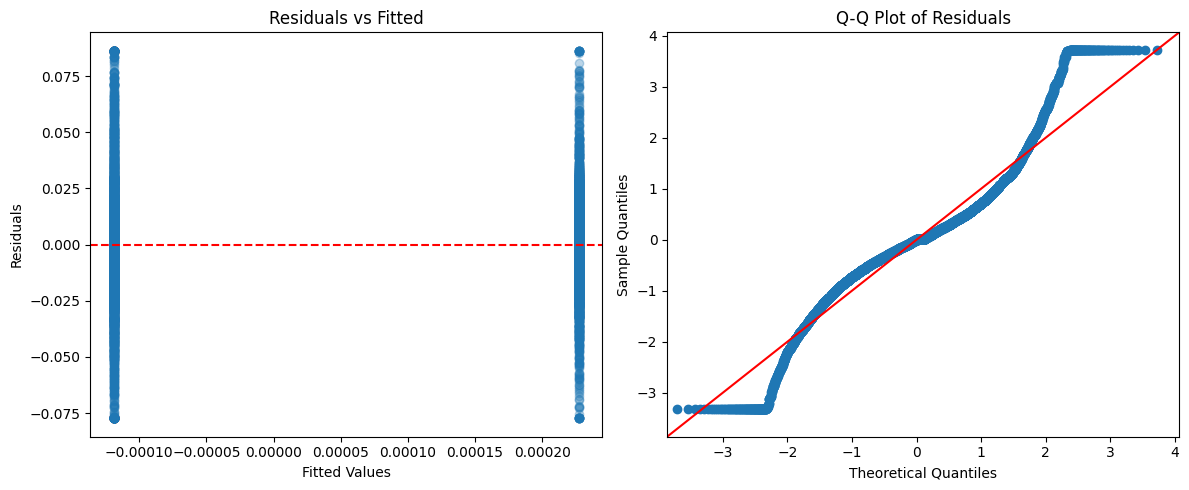

In [26]:
model = ols("Winsorized_Return ~ Category_num", data=data).fit(cov_type="HC3")
resid = model.resid
fitted = model.fittedvalues

# --- Independence ---
print("Durbin-Watson:", durbin_watson(resid))

# --- Normality ---
jb_stat, jb_p, skew, kurtosis = jarque_bera(resid)
print(f"Jarque-Bera: stat={jb_stat:.3f}, p={jb_p:.3f}, skew={skew:.3f}, kurt={kurtosis:.3f}")

# --- Plots side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuals vs Fitted
axes[0].scatter(fitted, resid, alpha=0.3)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Fitted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted")

# Q-Q plot
sm.qqplot(resid, line="45", fit=True, ax=axes[1])
axes[1].set_title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

* Independence:  satisfied.
* Linearity: trivial (binary predictor, group mean comparison).
* Homoscedasticity:  satisfied (residuals stable).
* Normality:  violated (heavy tails remain, as expected in finance).

##### Log_Volatility_20

Durbin-Watson: 0.04128194017649693
Jarque-Bera: stat=165.591, p=0.000, skew=0.300, kurt=3.204


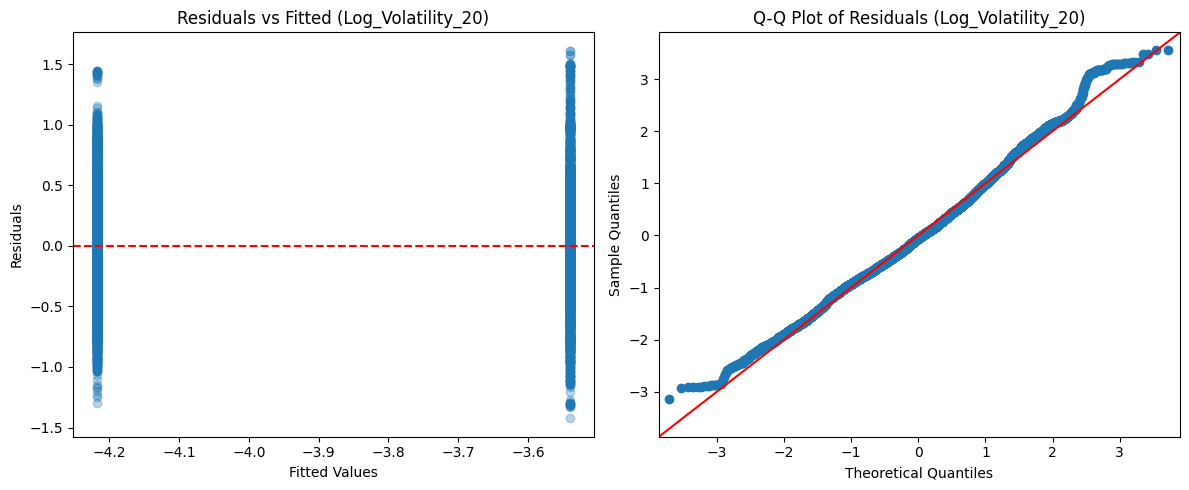

In [27]:
model = ols("Log_Volatility_20 ~ Category_num", data=data).fit(cov_type="HC3")
resid = model.resid
fitted = model.fittedvalues

# --- Independence ---
print("Durbin-Watson:", durbin_watson(resid))

# --- Normality ---
jb_stat, jb_p, skew, kurtosis = jarque_bera(resid)
print(f"Jarque-Bera: stat={jb_stat:.3f}, p={jb_p:.3f}, skew={skew:.3f}, kurt={kurtosis:.3f}")

# --- Plots side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuals vs Fitted
axes[0].scatter(fitted, resid, alpha=0.3)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Fitted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted (Log_Volatility_20)")

# Q-Q plot
sm.qqplot(resid, line="45", fit=True, ax=axes[1])
axes[1].set_title("Q-Q Plot of Residuals (Log_Volatility_20)")

plt.tight_layout()
plt.show()

* Independence: violated (DW ≈ 0, strong autocorrelation, expected due to rolling window).
* Linearity:  trivial (binary predictor).
* Homoscedasticity:  satisfied.
* Normality:  formally rejected (JB), but residuals look “normal enough” for robust SE inference.

##### Log_CumReturn

Durbin-Watson: 0.004245714733873747
Jarque-Bera: stat=67613.997, p=0.000, skew=-2.890, kurt=14.438


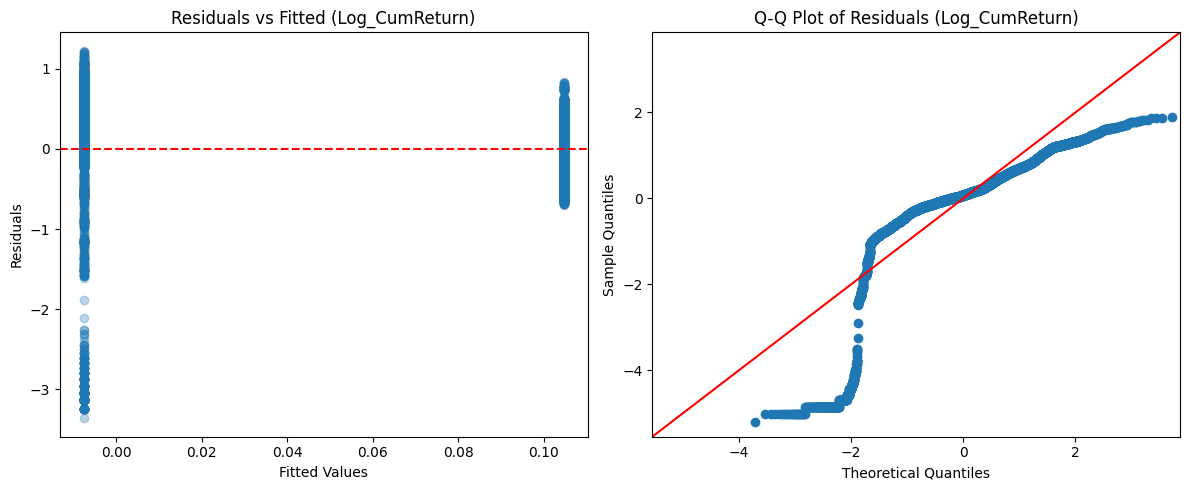

In [28]:
model = ols("Log_CumReturn ~ Category_num", data=data).fit(cov_type="HC3")
resid = model.resid
fitted = model.fittedvalues

# --- Independence ---
print("Durbin-Watson:", durbin_watson(resid))

# --- Normality ---
jb_stat, jb_p, skew, kurtosis = jarque_bera(resid)
print(f"Jarque-Bera: stat={jb_stat:.3f}, p={jb_p:.3f}, skew={skew:.3f}, kurt={kurtosis:.3f}")

# --- Plots side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuals vs Fitted
axes[0].scatter(fitted, resid, alpha=0.3)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Fitted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted (Log_CumReturn)")

# Q-Q plot
sm.qqplot(resid, line="45", fit=True, ax=axes[1])
axes[1].set_title("Q-Q Plot of Residuals (Log_CumReturn)")

plt.tight_layout()
plt.show()

* Independence:  violated (DW ≈ 0).
* Linearity:  trivial (binary predictor).
* Homoscedasticity:  looks questionable (variance differs between groups).
* Normality:  strongly violated (skew and fat tails).

## **linear regression (OLS)**

In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# --- Winsorized Daily Returns ---
model_return = ols("Winsorized_Return ~ Category_num", data=data).fit(cov_type="HC3")

# --- Log Volatility (20-day) ---
model_vol = ols("Log_Volatility_20 ~ Category_num", data=data).fit(cov_type="HC3")

# --- Log Cumulative Return ---
model_cum = ols("Log_CumReturn ~ Category_num", data=data).fit(cov_type="HC3")

# --- Print results ---
print("===== Winsorized Daily Returns =====")
print(model_return.summary())

print("\n===== Log Volatility (20-day) =====")
print(model_vol.summary())

print("\n===== Log Cumulative Returns =====")
print(model_cum.summary())

===== Winsorized Daily Returns =====
                            OLS Regression Results                            
Dep. Variable:      Winsorized_Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3914
Date:                Mon, 25 Aug 2025   Prob (F-statistic):              0.532
Time:                        21:36:16   Log-Likelihood:                 23143.
No. Observations:                9880   AIC:                        -4.628e+04
Df Residuals:                    9878   BIC:                        -4.627e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept  

* Daily Returns → No difference. **Core and Extra firms have similar average daily performance.**
* Volatility → **Extra firms are much less volatile**, Category explains a large portion of variance (R² = 0.345).
* Cumulative Returns → **Extra firms have modestly higher long-run returns.** Effect is statistically significant but small (R² = 0.007).

Investor Interpretation
* Extra companies = safer, more stable, slightly better long-term growth.
* Core companies = riskier, with higher volatility and more dispersed outcomes, but not delivering higher average returns.
* For risk-averse investors, Extra firms are the better choice.